# This note book visualizes the experiment performance
<b>You just have to pass the experiment saved directory as a dictionary parameter. It is designed to create plots for individual experiment, compare two or more experiments or compare all the experiments in the directory. By default it compares all experiments.</b>

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import json
import argparse
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from tensorboard.plugins.hparams import plugin_data_pb2
import seaborn as sns
import operator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator
sns.set()


In [2]:
def read_tf_event_file(tfevent_file:str):
    import glob
    all_tf_files_in_folder = []
    for f in glob.glob(tfevent_file + '/*/*.out.*', recursive=True):
        all_tf_files_in_folder.append(f)
    for f in glob.glob(tfevent_file + '/*.out.*', recursive=True):
        all_tf_files_in_folder.append(f)

    run_config = {}
    parameter_config = {}

    for tfevent_file in all_tf_files_in_folder:
        # Read in tensorflow summary file
        event_acc = EventAccumulator(path=tfevent_file)
        event_acc.Reload()

        # Get Scalars
        for scalar_summary_key in event_acc.Tags()['scalars']:
            _, step_nums, values = zip(*event_acc.Scalars(scalar_summary_key))
            run_config[scalar_summary_key] = values

        if 'Hyperparameters/text_summary' in event_acc.Tags():
            # Get Hyperparameters and others:
            for ten_ev in event_acc.Tensors(tag='Hyperparameters/text_summary'):
                vals_byte = (ten_ev.tensor_proto.string_val[0])
                vals = vals_byte.decode('utf-8')

                key, val = vals.replace(" ", "").split(":")
                assert key not in parameter_config.keys()
                parameter_config[key] = val

        if 'Other Parameters/text_summary' in event_acc.Tags():
            for ten_ev in event_acc.Tensors(tag='Other Parameters/text_summary'):
                vals_byte = (ten_ev.tensor_proto.string_val[0])
                vals = vals_byte.decode('utf-8')
                key, val = vals.replace(" ", "").split(":")
                assert key not in parameter_config.keys()
                parameter_config[key] = val

        md_keys = list(event_acc.summary_metadata)
        for k in md_keys:
            data = event_acc.summary_metadata[k]

            plugin_data = plugin_data_pb2.HParamsPluginData.FromString(data.plugin_data.content)
            if plugin_data.HasField("session_start_info"):
                ks = list(plugin_data.session_start_info.hparams.keys())
                for kss in ks:
                    parameter_config[kss] = plugin_data.session_start_info.hparams[kss].number_value
    return parameter_config

<b>get_legend </b>function recieves the parameters used by the experiment and returns the legend for ploting the graph by appending the parameter values.

In [3]:
def get_legend(param_data, plot_config, folder):

    if "num_of_optimizers" not in param_data.keys():
        print("#########################")
        print(folder)
        print("#########################")
        return "Unknown"
    else:
        if not plot_config["show_folder_in_legend"]:
            folder = ""
        plot_config["num_of_epochs"] = param_data["num_of_epochs"]
        num_optimizers = param_data['num_of_optimizers']
        num_warmup_steps1 = param_data["num_warmup_steps1"]
        optimizer_1_beta1 = param_data["optimizer_1_beta1"]
        optimizer_1_beta2 = param_data["optimizer_1_beta2"]

        num_warmup_steps2 = param_data["num_warmup_steps2"]
        optimizer_2_beta1 = param_data["optimizer_2_beta1"]
        optimizer_2_beta2 = param_data["optimizer_2_beta2"]
        optimizer_2_beta2 = param_data["optimizer_2_beta2"]

        if num_optimizers == 2:
            legend = str(folder)+"[" + str(int(num_warmup_steps1)) + ", " + str(
                optimizer_1_beta2) + "]" + "[" + str(int(num_warmup_steps2)) + ", " + str(optimizer_2_beta2) + "]"
            #legend = str(folder)+"[" + str(int(num_warmup_steps1)) +"]" + "[" + str(int(num_warmup_steps2)) +  "]"
            #legend = str(folder) + "[" + str(optimizer_1_beta2) + "]" + "[" + str(optimizer_2_beta2) + "]"
        else:
            legend = str(folder)+"[" + str(int(num_warmup_steps1)) + ", " + str(
                optimizer_1_beta2) + "]"
            #legend = str(folder)+"[" + str(int(num_warmup_steps1)) + "]"
            #legend = str(folder) + "[" + str(optimizer_1_beta2) + "]"
    return legend

In [4]:
def initialize_plot_config(plot_config):
    config_keys = plot_config.keys()
    if "experiment_dir" not in config_keys:
        raise ValueError("experiment_dir cannot be empty")
    if "experiments" not in config_keys:
        plot_config["experiments"] = ""
    if "batch_size" not in config_keys:
        plot_config["batch_size"] = 1000
    if "num_of_epochs" not in config_keys:
        plot_config["num_of_epochs"] = 20
    if "resolution" not in config_keys:
        plot_config["resolution"] = 80
    if "save_plots" not in config_keys:
        plot_config["save_plots"] = False
    if "display_epoch" not in config_keys:
        plot_config["display_epoch"] = True
    if "show_folder_in_legend" not in config_keys:
        plot_config["show_folder_in_legend"] = True
    return plot_config

# Function to plot training loss for multiple experminents

In [5]:
def plot_train_loss(experiments_to_plot, plot_config, experiment_event_map):
    fig = plt.figure("Training loss", figsize=(12, 8), dpi=plot_config["resolution"])
    for folder in experiments_to_plot:
        tf_event_file_path = os.path.join(plot_config["experiment_dir"], "runs", folder)
        param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
        legend = get_legend(param_data, plot_config, folder)

        train_loss = []

        for e in summary_iterator(
                os.path.join(plot_config["experiment_dir"], "runs", folder, experiment_event_map[folder])):
            for v in e.summary.value:
                if v.tag == "training_loss":
                    train_loss.append(v.simple_value)

        if plot_config["display_epoch"]:
            training_loss = []
            sum = 0
            for i in range(len(train_loss)):
                sum += train_loss[i]
                if i != 0 and i % int((len(train_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                    training_loss.append(sum / (len(train_loss) / plot_config["num_of_epochs"]))
                    sum = 0
        else:
            training_loss = train_loss

        plt.plot(training_loss[:10], label=legend)

    if plot_config["display_epoch"]:
        plt.xlabel("epoch")
    else:
        plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training loss")
    plt.legend(prop={'size': 10})
    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], plot_config["training_loss_save_name"]),
                    dpi=plot_config["resolution"])
    plt.show()


#  Function to plot validation loss for multiple experiments

In [6]:
def plot_validation_loss(experiments_to_plot, plot_config, experiment_event_map):
    fig = plt.figure("Validation loss", figsize=(12, 8), dpi=plot_config["resolution"])
    for folder in experiments_to_plot:
        tf_event_file_path = os.path.join(plot_config["experiment_dir"], "runs", folder)
        param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
        legend = get_legend(param_data, plot_config, folder)

        valid_loss = []

        for e in summary_iterator(
                os.path.join(plot_config["experiment_dir"], "runs", folder, experiment_event_map[folder])):
            for v in e.summary.value:
                if v.tag == "val_loss":
                    valid_loss.append(v.simple_value)

        if plot_config["display_epoch"]:
            validation_loss = []
            sum = 0
            for i in range(len(valid_loss)):
                sum += valid_loss[i]
                if i != 0 and i % int((len(valid_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                    validation_loss.append(sum / (len(valid_loss) / plot_config["num_of_epochs"]))
                    sum = 0
        else:
            validation_loss = valid_loss

        plt.plot(validation_loss[:10], label=legend)

    if plot_config["display_epoch"]:
        plt.xlabel("epoch")
    else:
        plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Validation loss")
    plt.legend(prop={'size': 10})
    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], plot_config["validation_loss_save_name"]),
                    dpi=plot_config["resolution"])
    plt.show()


# Function to plot BLEU score

In [7]:
def plot_bleu_score(experiments_to_plot, plot_config, experiment_event_map):
    fig = plt.figure("Validation BLEU score", figsize=(12, 8), dpi=plot_config["resolution"])
    legend_map = {}
    color_codes = ["b", "g", "r", "c", "m", "y", "black", "tab:orange", "tab:brown", "tab:pink", "tab:purple", "aqua", "grey", "darkgoldenrod", "maroon", "darkkhaki"]
    for folder in experiments_to_plot:
        tf_event_file_path = os.path.join(plot_config["experiment_dir"], "runs", folder)
        param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
        legend = get_legend(param_data, plot_config, folder)
        legend_map[folder+legend] = [folder, legend]

    for index, key in enumerate(sorted(legend_map)):
        folder = legend_map[key][0]
        legend = key
        #tf_event_file_path = os.path.join(plot_config["experiment_dir"], "runs", folder)
        #param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
        #legend = get_legend(param_data, plot_config, folder)

        bleu_score = []

        for e in summary_iterator(
                os.path.join(plot_config["experiment_dir"], "runs", folder, experiment_event_map[folder])):
            for v in e.summary.value:
                if v.tag == "bleu_score":
                    bleu_score.append(v.simple_value)
        legend_map[key].append(bleu_score)
        legend_map[key].append(np.max(bleu_score))

    # legend map contains a list with three values. folder name, blue score list and maximum blue score in the list
    #sort with key: key=lambda x: (float(x[0].split("[")[1].split("]")[0]), float(x[0].split("[")[2].split("]")[0]))
    # based on blue score: key=lambda x: x[1][2]
    for index, (key, value) in enumerate(sorted(legend_map.items(), key=lambda x: x[1][3], reverse=True)):
        max_bleu = value[3]
        #print(key, max_bleu)
        plt.plot(value[2][:10], label=f'{max_bleu:.3f}' + " " + value[1])


    plt.xlabel("epoch")
    plt.ylabel("BLEU score")
    plt.title("Validation BLEU score")
    plt.xticks(np.arange(0, 10, 2))
    plt.legend(bbox_to_anchor=(1.02, 1), loc='best', prop={'size': 6}, borderaxespad=0.)
    plt.tight_layout()
    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], plot_config["bleu_score_save_name"]),
                    dpi=plot_config["resolution"])
    plt.show()


# Function to plot train and validation loss for a single experiment

In [8]:
def plot_train_val_loss(experiments_to_plot, plot_config, experiment_event_map):
    fig = plt.figure("Training and Validation loss", figsize=(12, 8), dpi=plot_config["resolution"])
    folder = experiments_to_plot
    tf_event_file_path = os.path.join(plot_config["experiment_dir"], "runs", folder)
    param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
    #print(tf_event_file_path)

    legend = get_legend(param_data, plot_config, folder)

    valid_loss = []
    train_loss = []

    for e in summary_iterator(
            os.path.join(plot_config["experiment_dir"], "runs", folder, experiment_event_map[folder])):
        for v in e.summary.value:
            if v.tag == "val_loss":
                valid_loss.append(v.simple_value)
            if v.tag == "training_loss":
                train_loss.append(v.simple_value)

    if plot_config["display_epoch"]:
        validation_loss = []
        sum = 0
        for i in range(len(valid_loss)):
            sum += valid_loss[i]
            if i != 0 and i % int((len(valid_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                validation_loss.append(sum / (len(valid_loss) / plot_config["num_of_epochs"]))
                sum = 0
        training_loss = []
        sum = 0
        for i in range(len(train_loss)):
            sum += train_loss[i]
            if i != 0 and i % int((len(train_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                training_loss.append(sum / (len(train_loss) / plot_config["num_of_epochs"]))
                sum = 0
    else:
        validation_loss = valid_loss
        training_loss = train_loss

    plt.plot(training_loss, label="Training:" + legend)
    plt.plot(validation_loss, label="Validation:" + legend)

    if plot_config["display_epoch"]:
        plt.xlabel("epoch")
    else:
        plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training and Validation loss")
    plt.legend()
    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], plot_config["train_val_loss_save_name"]),
                    dpi=plot_config["resolution"])
    plt.show()

<b>Plot_graph</b> function recieves the configuration to plot the graphs. It plots three graphs which includes Training loss, Validation loss and BLEU score against the number of epochs/steps. The configurations are as below<br>

<ul>
    <li><b>experiment_dir</b>: Directory where the experiments are saved</li>
<li><b>experiments</b>: Comma separated values of experiment folders.
    <ol>
        <li>If no experiment specified then by default all the experimets in the directory are compared.</li>
            <li> To compare two are more experiments then provide the name of the experiments as comma separated                    values. Eg: 20210627144614.409041,20210628112858.368135</li>
        <li> To plot a single experiment provide the folder name of experiment. Eg: 20210628112858.368135 </li>
    </ol></li>
    <li><b>batch_size</b>: The batch size with which the experiments have run. Deafault value is 1000.</li>
    <li><b>num_of_epochs</b>: Number of epochs the experiments have run. Default value is 20.</li>
    <li><b>resolution</b>: Resolution of the plot to be displayed. Default value is 80.</li>
    <li><b>save_plots</b>: whether to save the created plots. If it is set to true then it saves the plots in the experiment directory. By default the value is false.</li> 
    <li><b>display_epoch</b>: Loss values are saved for each steps instead of epoch. To make visualization better we are plotig the values for each epoch using conversion. By default this value is true and we are doing conversion.</li>  
    </ul>

In [9]:
def plot_graph(plot_config):
    plot_config = initialize_plot_config(plot_config)

    training_loss_save_name = "all_training_loss.jpg"
    validation_loss_save_name = "all_validation_loss.png"
    bleu_score_save_name = "all_bleu_score.png"
    train_val_loss_save_name = "train_val_loss.png"

    experiments_to_plot = [f for f in os.listdir(os.path.join(plot_config["experiment_dir"], "runs"))]

    # by default we compare all experiments in the directory. If the value is provided then only specific experiments are plotted in the graph
    if plot_config["experiments"] != "":
        experiments = plot_config["experiments"].split(",")
        experiments_to_plot = list(set(experiments) & set(experiments_to_plot))
        # remove if any spaces at the end of names
        experiments_to_plot = [folder_name.strip() for folder_name in experiments_to_plot]

        separator = ":"
        training_loss_save_name = separator.join(experiments_to_plot) + "_training_loss.jpg"
        validation_loss_save_name = separator.join(experiments_to_plot) + "_validation_loss.png"
        bleu_score_save_name = separator.join(experiments_to_plot) + "_bleu_score.png"
        train_val_loss_save_name = separator.join(experiments_to_plot) + "_train_val_loss.png"

    plot_config["training_loss_save_name"] = training_loss_save_name
    plot_config["validation_loss_save_name"] = validation_loss_save_name
    plot_config["bleu_score_save_name"] = bleu_score_save_name
    plot_config["train_val_loss_save_name"] = train_val_loss_save_name

    experiment_event_map = {}
    for f in experiments_to_plot:
        for file in os.listdir(os.path.join(plot_config["experiment_dir"], "runs", f)):
            if os.path.isfile(os.path.join(plot_config["experiment_dir"], "runs", f, file)) and file.startswith(
                    "events"):
                experiment_event_map[f] = file


    if len(experiments_to_plot) > 1:
        plot_train_loss(experiments_to_plot, plot_config, experiment_event_map)
        plot_validation_loss(experiments_to_plot, plot_config, experiment_event_map)
    else:
        plot_train_val_loss(experiments_to_plot[0], plot_config, experiment_event_map)

    plot_bleu_score(experiments_to_plot, plot_config, experiment_event_map)



In [11]:
def plot_mean_variance(plot_config):
    plot_config = initialize_plot_config(plot_config)

    experiment_map = {}
    experiments = [f for f in os.listdir(plot_config["experiment_dir"]) if not os.path.isfile(os.path.join(plot_config["experiment_dir"], f))]

    for folder in experiments:
        experiment_folders = [f for f in os.listdir(os.path.join(plot_config["experiment_dir"], folder, "runs"))]

        for experiment in experiment_folders:
            tf_event_file_path = os.path.join(plot_config["experiment_dir"], folder, "runs", experiment)
            param_data = read_tf_event_file(tfevent_file=tf_event_file_path)
            #print(tf_event_file_path)
            legend = get_legend(param_data, plot_config, "")
            if legend != "":
                key = legend

                if key not in experiment_map:
                    experiment_map[key] = []
                    experiment_map[key].append(os.path.join(plot_config["experiment_dir"], folder, "runs", experiment))
                else:
                    experiment_map[key].append(os.path.join(plot_config["experiment_dir"], folder, "runs", experiment))

    all_experiments_data = {}
    color_codes = ["b", "g", "r", "c", "m", "y", "tab:orange", "tab:brown", "tab:pink", "tab:purple", "aqua",
                   "grey", "darkgoldenrod", "maroon", "darkkhaki", "slateblue", "rosybrown", "darkred", "chocolate",
                   "olive", "violet", "teal", "lime", "darkcyan", "greenyellow", "darkmagenta", "thistle", "crimson",
                   "gold", "tan", "slategrey", "orchid", "darkslategrey"]
    for key in experiment_map:
        try:
            print(key)
            train_data = []
            val_data = []
            bleu_data = []

            fig, ax = plt.subplots(2, figsize=(12, 8), dpi=plot_config["resolution"])
            fig.subplots_adjust(hspace=0.5)
            for file_path in  experiment_map[key]:
                valid_loss = []
                train_loss = []
                bleu_score = []

                for file in os.listdir(file_path):
                    if os.path.isfile(os.path.join(file_path, file)) and file.startswith("event"):
                        for e in summary_iterator(os.path.join(file_path, file)):
                            for v in e.summary.value:
                                if v.tag == "val_loss":
                                    valid_loss.append(v.simple_value)
                                if v.tag == "training_loss":
                                    train_loss.append(v.simple_value)
                                if v.tag == "bleu_score":
                                    bleu_score.append(v.simple_value)


                        if plot_config["display_epoch"]:
                            validation_loss = []
                            sum = 0
                            for i in range(len(valid_loss)):
                                sum += valid_loss[i]
                                if i != 0 and i % int((len(valid_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                                    validation_loss.append(sum / (len(valid_loss) / plot_config["num_of_epochs"]))
                                    sum = 0
                            training_loss = []
                            sum = 0
                            for i in range(len(train_loss)):
                                sum += train_loss[i]
                                if i != 0 and i % int((len(train_loss) / plot_config["num_of_epochs"]) - 1) == 0:
                                    training_loss.append(sum / (len(train_loss) / plot_config["num_of_epochs"]))
                                    sum = 0
                        else:
                            validation_loss = valid_loss
                            training_loss = train_loss

                        train_data.append(training_loss)
                        val_data.append(validation_loss)
                        bleu_data.append(bleu_score)


            all_experiments_data[key] = bleu_data

            min_length = min([len(data) for data in train_data])
            train_data = [data[: min_length] for data in train_data]
            mean = np.mean(train_data, axis=0)[:10]
            sd = np.std(train_data, axis=0)[:10]
            ax[0].plot(mean, label="Training")
            ax[0].fill_between(range(len(mean)), mean - sd, mean + sd, alpha=0.5)

            min_length = min([len(data) for data in val_data])
            val_data = [data[: min_length] for data in val_data]
            mean = np.mean(val_data, axis=0)[:10]
            sd = np.std(val_data, axis=0)[:10]
            ax[0].plot(mean, label="Validation")
            ax[0].fill_between(range(len(mean)), mean - sd, mean + sd, alpha=0.5)

            if plot_config["display_epoch"]:
                ax[0].set(xlabel="epoch")
            else:
                ax[0].set(xlabel="step")
            ax[0].set(ylabel="loss")
            ax[0].set_title("Training and Validation loss")
            ax[0].legend()

            min_length = min([len(data) for data in bleu_data])
            bleu_data = [data[: min_length] for data in bleu_data]
            mean = np.mean(bleu_data, axis=0)[:10]
            sd = np.std(bleu_data, axis=0)[:10]
            ax[1].plot(mean)
            ax[1].fill_between(range(len(mean)), mean - sd, mean + sd, alpha=0.5)
            ax[1].set(xlabel="epoch")
            ax[1].set(ylabel="BLEU score")
            ax[1].set_title("Validation BLEU score")

            fig.suptitle(key)


            if plot_config["save_plots"]:
                fig.savefig(os.path.join(plot_config["experiment_dir"], key+".jpg"),
                            dpi=plot_config["resolution"])
        except:
            print("Exception in :", key, experiment_map[key])


    fig = plt.figure(figsize=(12, 8), dpi=plot_config["resolution"])
    for index, key in enumerate(sorted(experiment_map, key=lambda x: np.max(np.mean(all_experiments_data[x], axis=0)), reverse=True)):
        min_length = min([len(data) for data in all_experiments_data[key]])
        all_experiments_data[key] = [data[: min_length] for data in all_experiments_data[key]]
        mean = np.mean(all_experiments_data[key], axis=0)[:10]
        sd = np.std(all_experiments_data[key], axis=0)[:10]
        max_bleu = np.max(mean)
        #print(len(key.split("]")))
        if len(key.split("]")) == 2:
            #baseline
            print("black")
            color = "black"
        else:
            color=color_codes[index]
        plt.plot(mean, label=f'{max_bleu:.3f}' + " " + key, color=color)
    #plt.yscale("log")
    plt.xlabel(xlabel="epoch")
    plt.ylabel(ylabel="BLEU score")
    plt.title("Validation BLEU score ff-att optimizers with beta2 variation")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='best', prop={'size': 11}, borderaxespad=0.)
    plt.xticks(np.arange(0, 10, 2))
    plt.tight_layout()

    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], "BLEU_score_no_variance.jpg"),
                    dpi=plot_config["resolution"])

    fig = plt.figure(figsize=(12, 8), dpi=plot_config["resolution"])
    #for index, key in enumerate(sorted(experiment_map, key=lambda x: (float(x.split("[")[1].split("]")[0])))):
    for index, key in enumerate(sorted(experiment_map, key=lambda x: np.max(np.mean(all_experiments_data[x], axis=0)), reverse=True)):
        min_length = min([len(data) for data in all_experiments_data[key]])
        all_experiments_data[key] = [data[: min_length] for data in all_experiments_data[key]]
        mean = np.mean(all_experiments_data[key], axis=0)[:10]
        sd = np.std(all_experiments_data[key], axis=0)[:10]
        max_bleu = np.max(mean)
        if len(key.split("]")) == 2:
            # baseline
            color = "black"
        else:
            color = color_codes[index]
        plt.plot(mean, label=f'{max_bleu:.3f}' + " " + key, color=color)
        plt.fill_between(range(len(mean)), mean - sd, mean + sd, alpha=0.5, color=color, linewidth=0.0)

    plt.xlabel(xlabel="epoch")
    plt.ylabel(ylabel="BLEU score")
    plt.title("Validation BLEU score ff-att optimizers with beta2 variation")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='best', prop={'size': 11}, borderaxespad=0.)
    #plt.xticks(np.arange(0, int(plot_config["num_of_epochs"]), 2))
    plt.xticks(np.arange(0, 10, 2))
    plt.tight_layout()

    if plot_config["save_plots"]:
        fig.savefig(os.path.join(plot_config["experiment_dir"], "BLEU_score.jpg"),
                    dpi=plot_config["resolution"])




Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


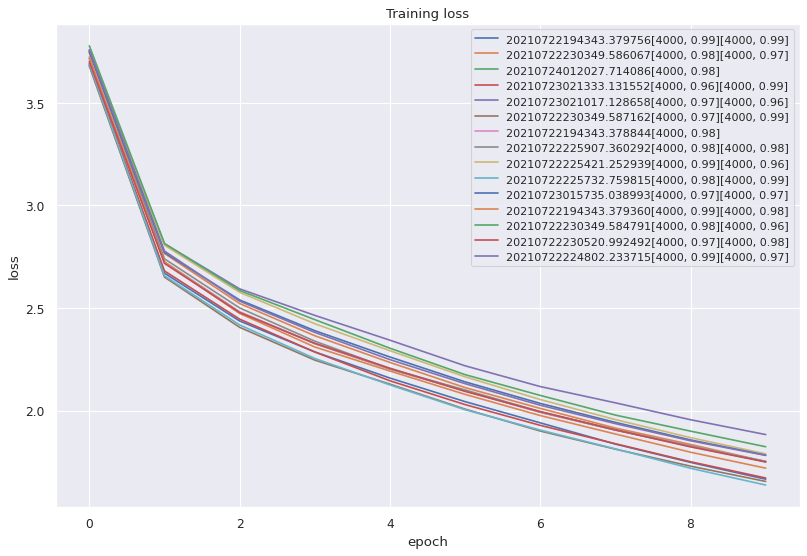

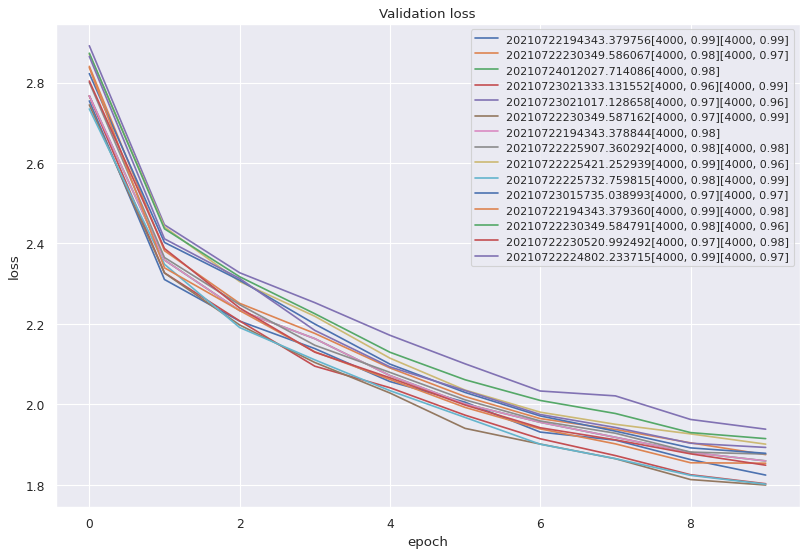

20210723015735.03899320210723015735.038993[4000, 0.97][4000, 0.97] 0.2567603588104248
20210722194343.37975620210722194343.379756[4000, 0.99][4000, 0.99] 0.2544309198856354
20210722230349.58716220210722230349.587162[4000, 0.97][4000, 0.99] 0.2532263398170471
20210722225421.25293920210722225421.252939[4000, 0.99][4000, 0.96] 0.2514011561870575
20210722230520.99249220210722230520.992492[4000, 0.97][4000, 0.98] 0.2502368092536926
20210722230349.58606720210722230349.586067[4000, 0.98][4000, 0.97] 0.25021958351135254
20210722194343.37936020210722194343.379360[4000, 0.99][4000, 0.98] 0.24968068301677704
20210724012027.71408620210724012027.714086[4000, 0.98] 0.24941731989383698
20210722194343.37884420210722194343.378844[4000, 0.98] 0.24941731989383698
20210723021017.12865820210723021017.128658[4000, 0.97][4000, 0.96] 0.249307781457901
20210722225732.75981520210722225732.759815[4000, 0.98][4000, 0.99] 0.24842147529125214
20210722230349.58479120210722230349.584791[4000, 0.98][4000, 0.96] 0.24778

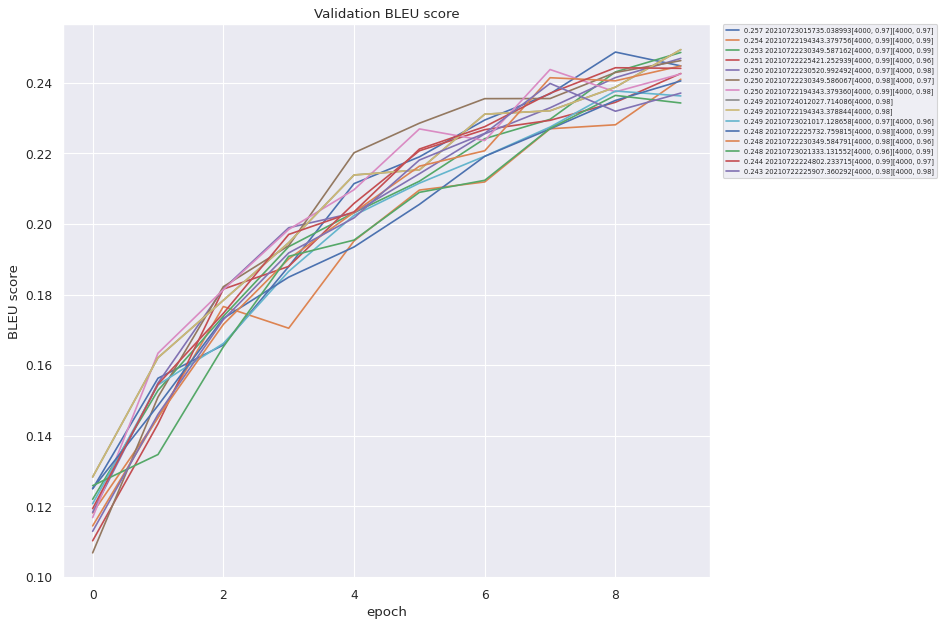

In [12]:
plot_config = dict()
plot_config["experiment_dir"] = "/home/kiran/kiran/dl_lab/project/project_experiments/Latest_experiments/enc-dec-beta2/enc-dec-beta2-kiran"
plot_config["experiments"] = ""
plot_config["num_of_epochs"] = 20
plot_config["batch_size"] = 1000
plot_config["resolution"] = 80
plot_config["save_plots"] = True
plot_config["display_epoch"] = True

plot_graph(plot_config)

In [52]:
plot_config = dict()
plot_config["experiment_dir"] = "/home/kiran/kiran/dl_lab/project/project_experiments/seeds/encdec_warmup"
plot_config["experiments"] = ""
plot_config["num_of_epochs"] = 20
plot_config["batch_size"] = 1000
plot_config["resolution"] = 80
plot_config["save_plots"] = True
plot_config["display_epoch"] = True
plot_config["show_folder_in_legend"] = False

#plot_mean_variance(plot_config)

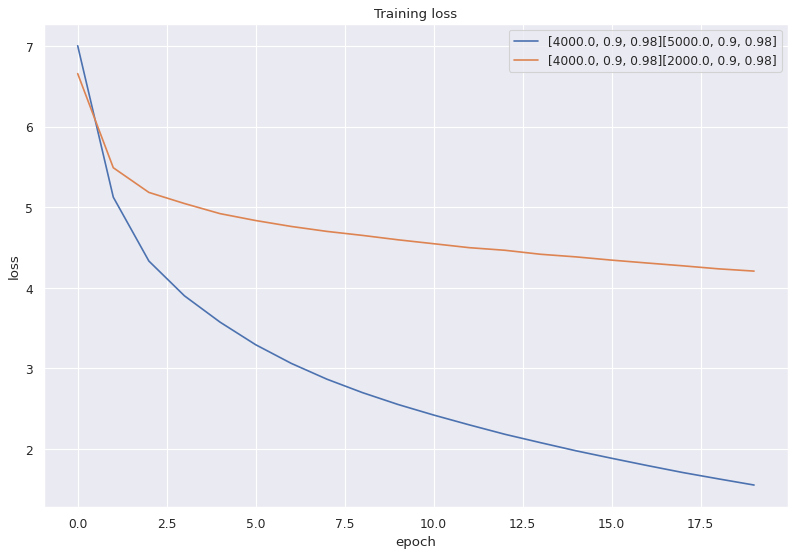

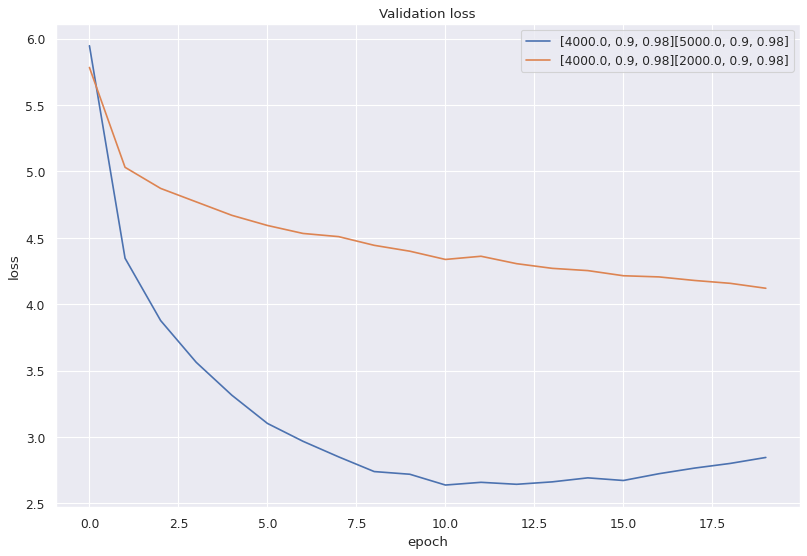

20210708143249.050029
[4000.0, 0.9, 0.98][5000.0, 0.9, 0.98]
20210708111551.372452
[4000.0, 0.9, 0.98][2000.0, 0.9, 0.98]


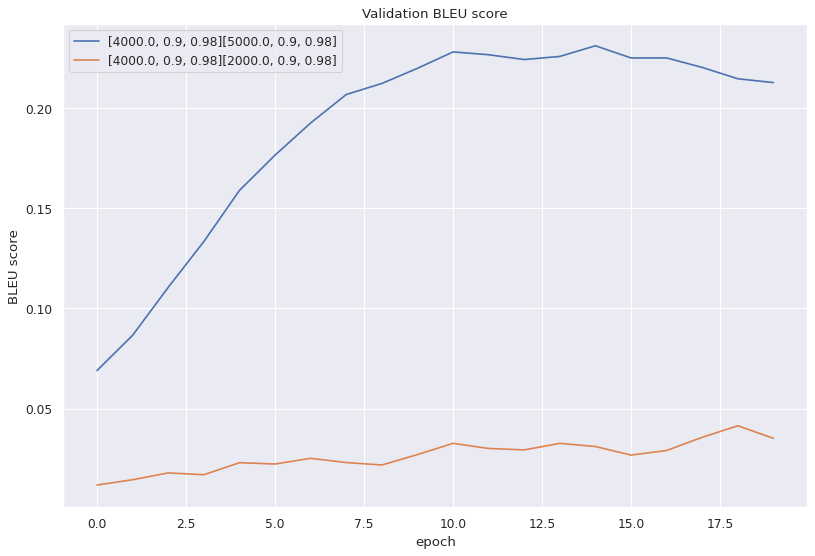

In [58]:
plot_config = dict()
plot_config["experiment_dir"] = "/home/kiran/kiran/dl_lab/project/project_experiments/seeds/encdec_warmup/encdec_warmup_kiran"
plot_config["experiments"] = "20210708143249.050029,20210708111551.372452"
plot_config["num_of_epochs"] = 20
plot_config["batch_size"] = 1000
plot_config["resolution"] = 80
plot_config["save_plots"] = True
plot_config["display_epoch"] = True

plot_graph(plot_config)